In [27]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
from math import log10

In [28]:
with np.load('dataset_filt_fir.npz') as data:
    ecg = {key: data[key] for key in data.keys()}
    
print(ecg)
data = ecg['base'].flatten()[0:20000]
fs = 1000

{'base': array([[ 3.5618e+02,  3.5618e+02,  3.5618e+02, ..., -0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [ 3.5524e+02,  3.5524e+02,  3.5524e+02, ..., -0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [ 3.5645e+02,  3.5645e+02,  3.5645e+02, ..., -0.0000e+00,
         0.0000e+00,  0.0000e+00],
       ...,
       [ 4.0845e+02,  4.0845e+02,  4.0845e+02, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [ 4.0250e+02,  4.0250e+02,  4.0250e+02, ...,  1.0000e-02,
         0.0000e+00,  0.0000e+00],
       [ 4.1612e+02,  4.1612e+02,  4.1612e+02, ...,  1.0000e-02,
         0.0000e+00,  0.0000e+00]]), 'target': array([0, 0, 0, ..., 2, 2, 2])}


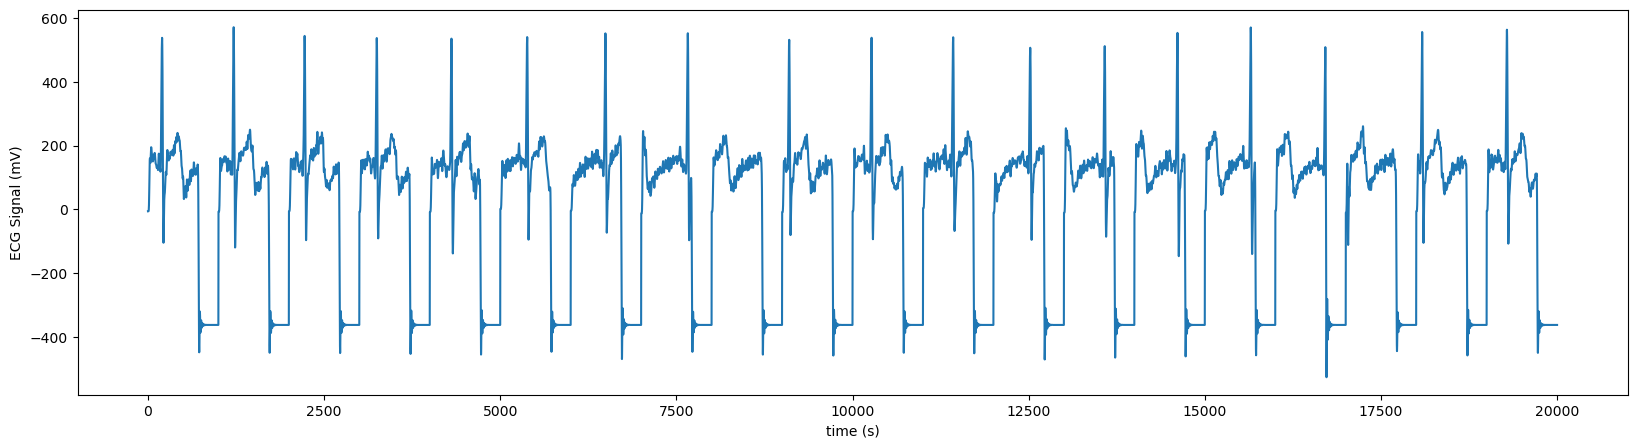

In [29]:
n = np.arange(len(data))
t = n/fs                        #Dominio
data = data - np.mean(data)     #Regularizamos las amplitudes


plt.figure(figsize=(20,5))
plt.plot(data)
plt.ylabel('ECG Signal (mV)')
plt.xlabel('time (s)')
plt.show()

## Analizamos la señal

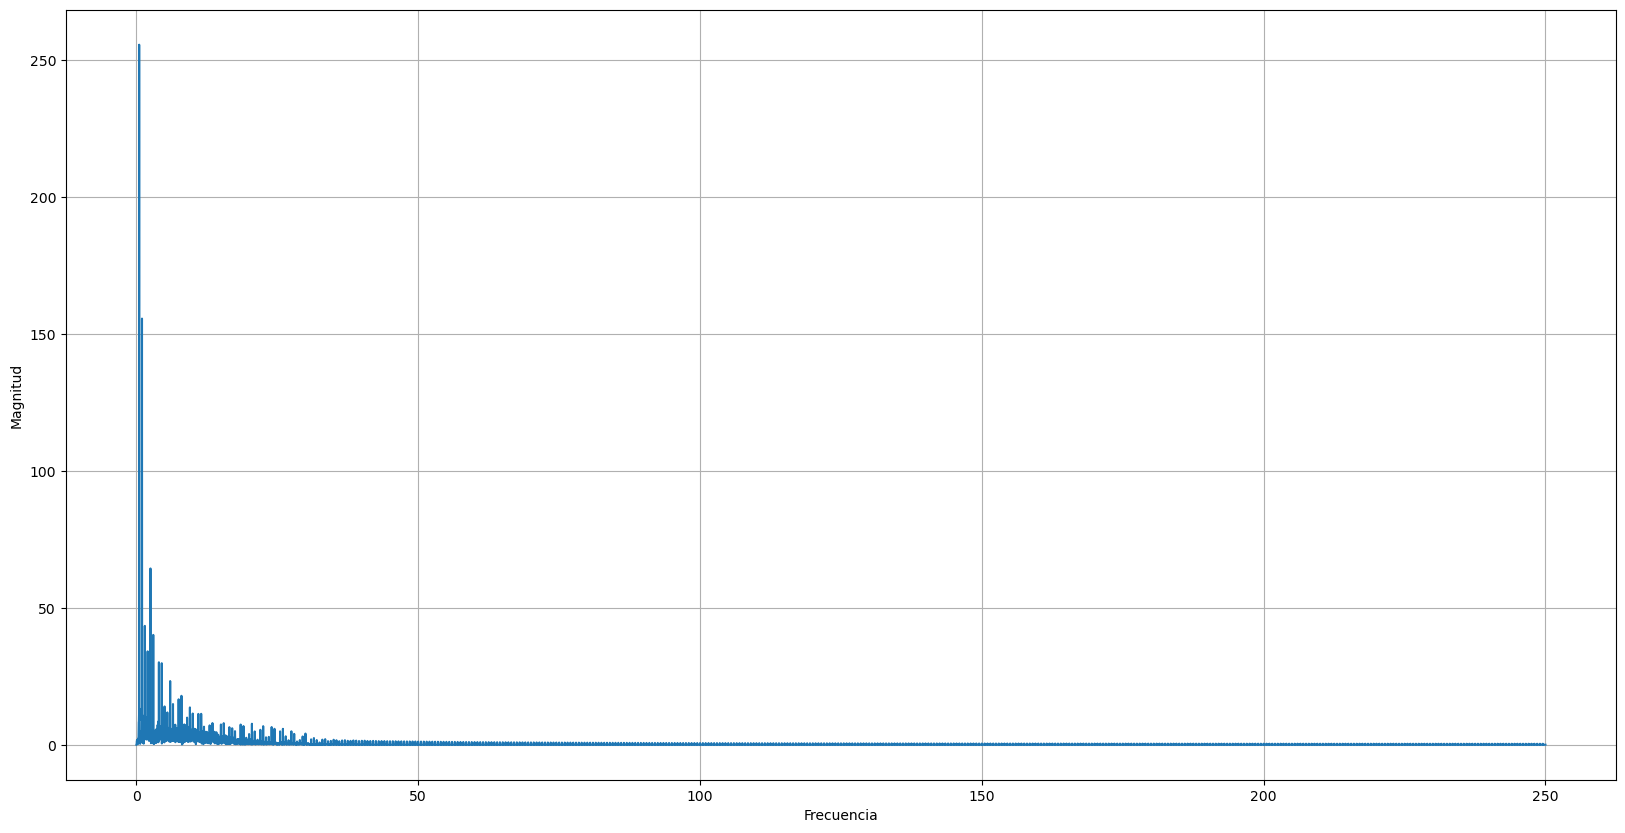

In [30]:
# Analizar el Fourier
senal_ecg = data

# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(senal_ecg)
yf = fft(senal_ecg)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

## Utilizamos filtros Notch para quitar frecuencias que hagan ruido
---

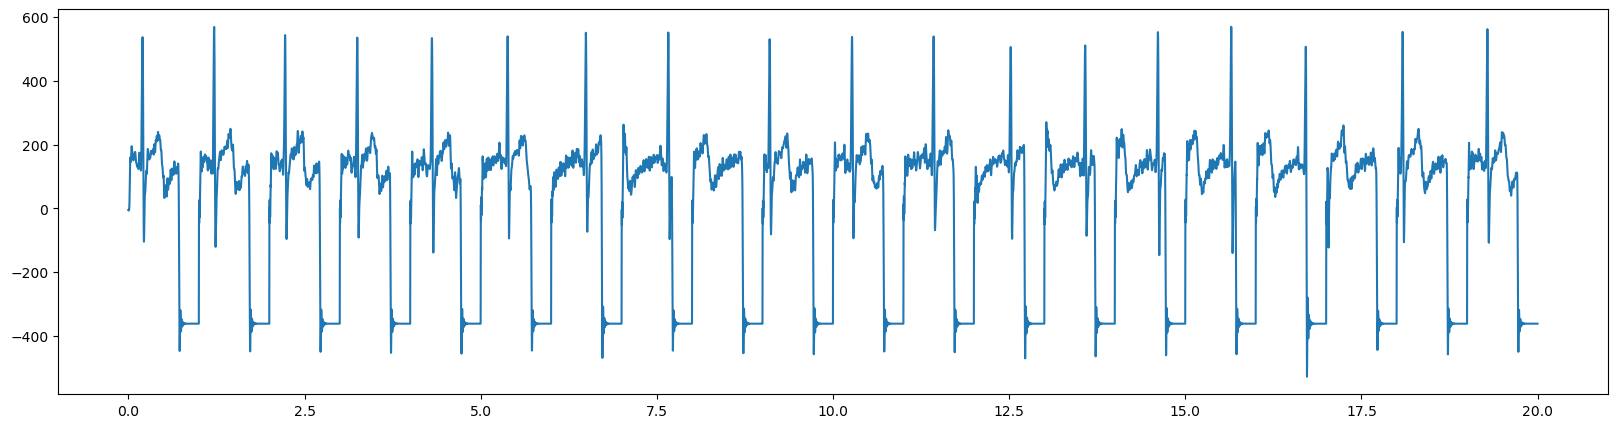

In [31]:
from scipy.signal import iirnotch, lfilter

fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 50.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch

b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, senal_ecg)
y = lfilter(b, a, y)

fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 150.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)


plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(t,y)
plt.show()

## Analisis de Fourier de los filtros
---

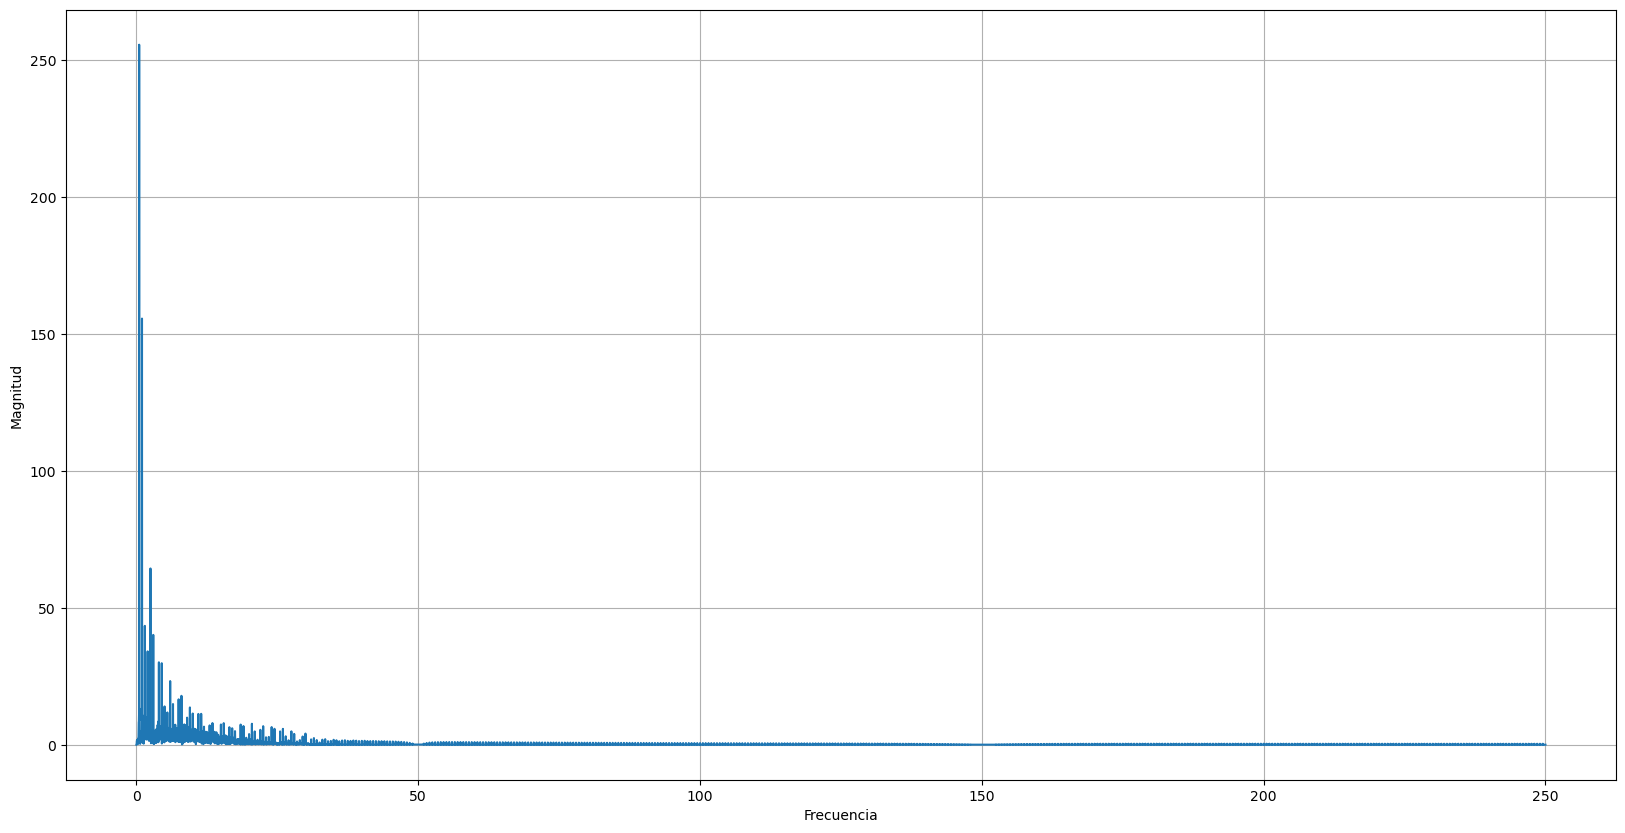

In [32]:
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(y)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()
ecg_signal = y

## Filtro pasa banda

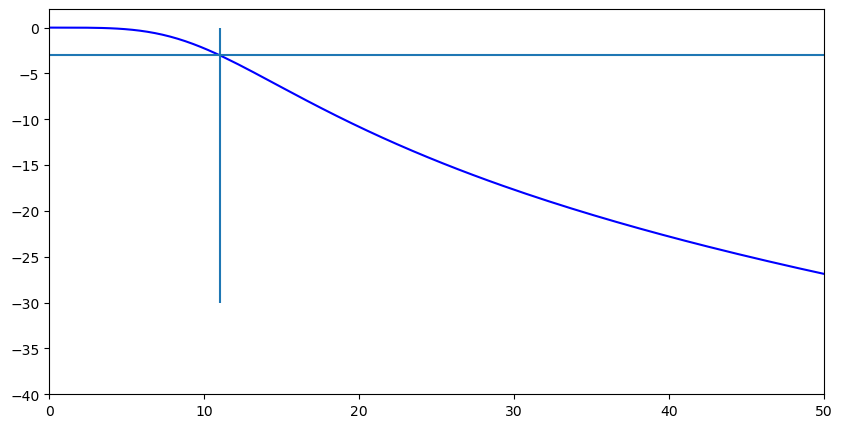

In [33]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)

plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

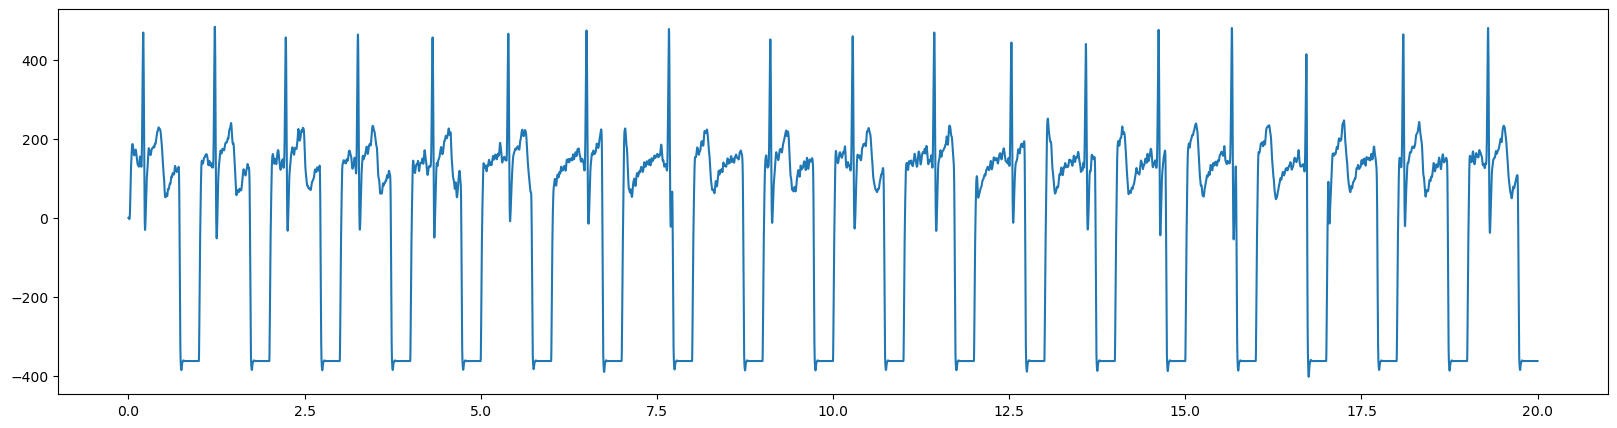

In [34]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpb_signal)
plt.show()

C:\Users\mauri\AppData\Local\Temp\ipykernel_18080\1635100386.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


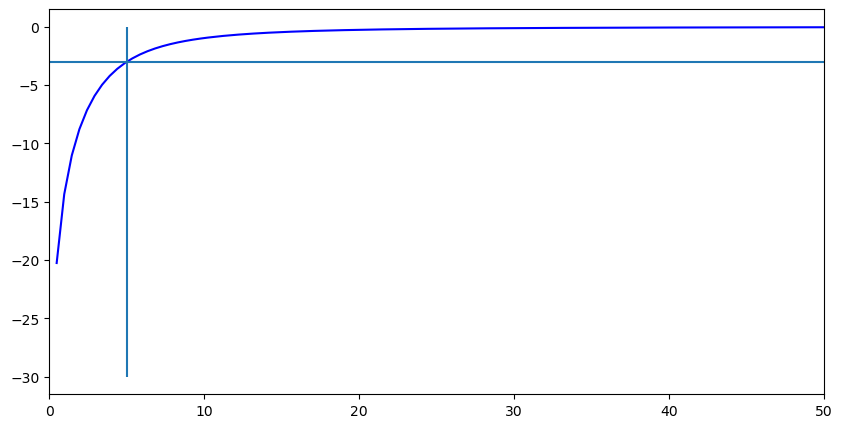

In [35]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()

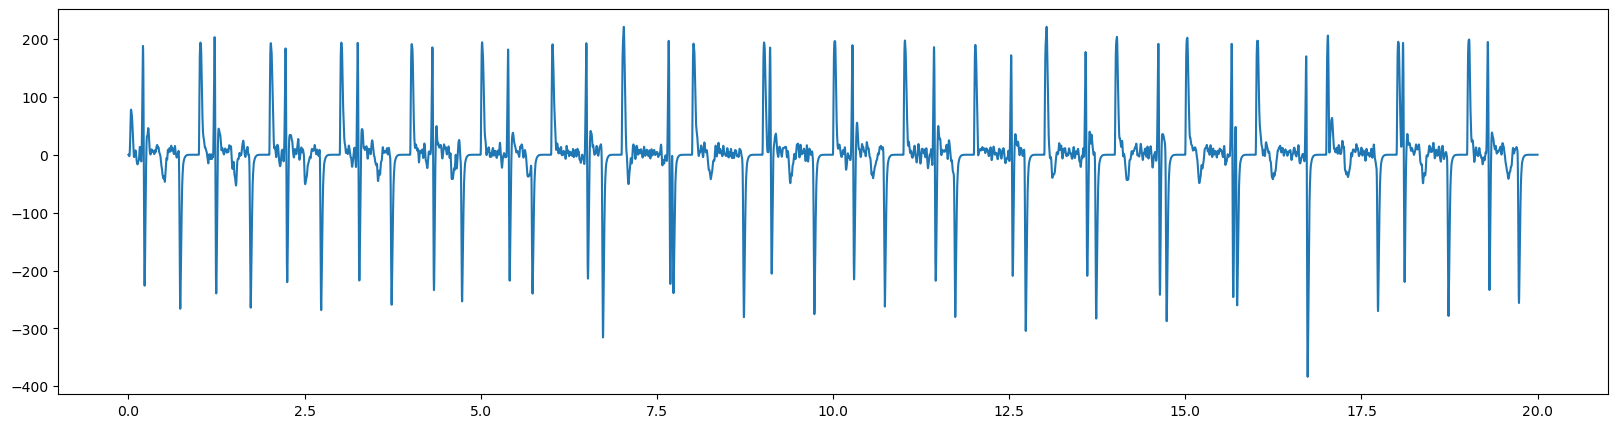

In [36]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fpa_signal)
plt.show()

C:\Users\mauri\AppData\Local\Temp\ipykernel_18080\73101146.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


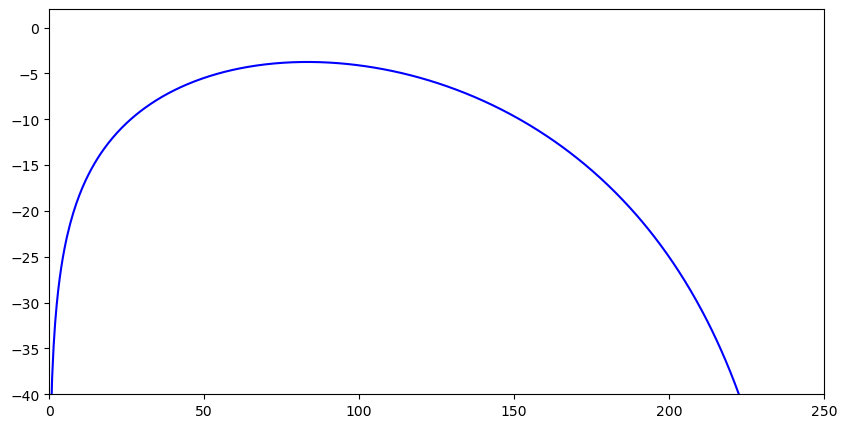

In [37]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

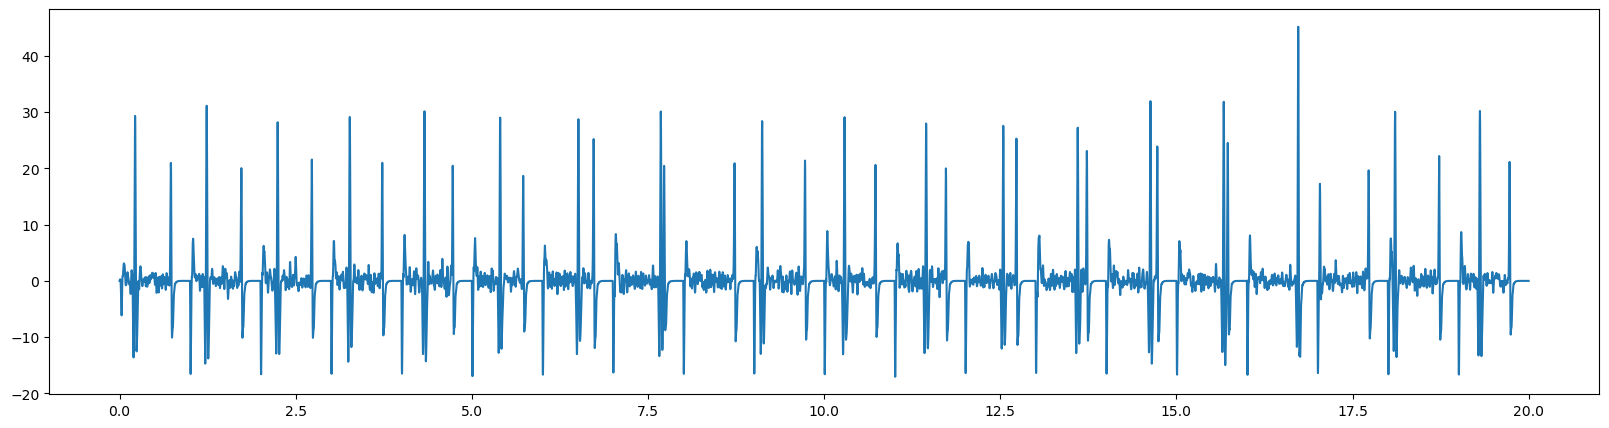

In [38]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(t,fd_signal)
plt.show()

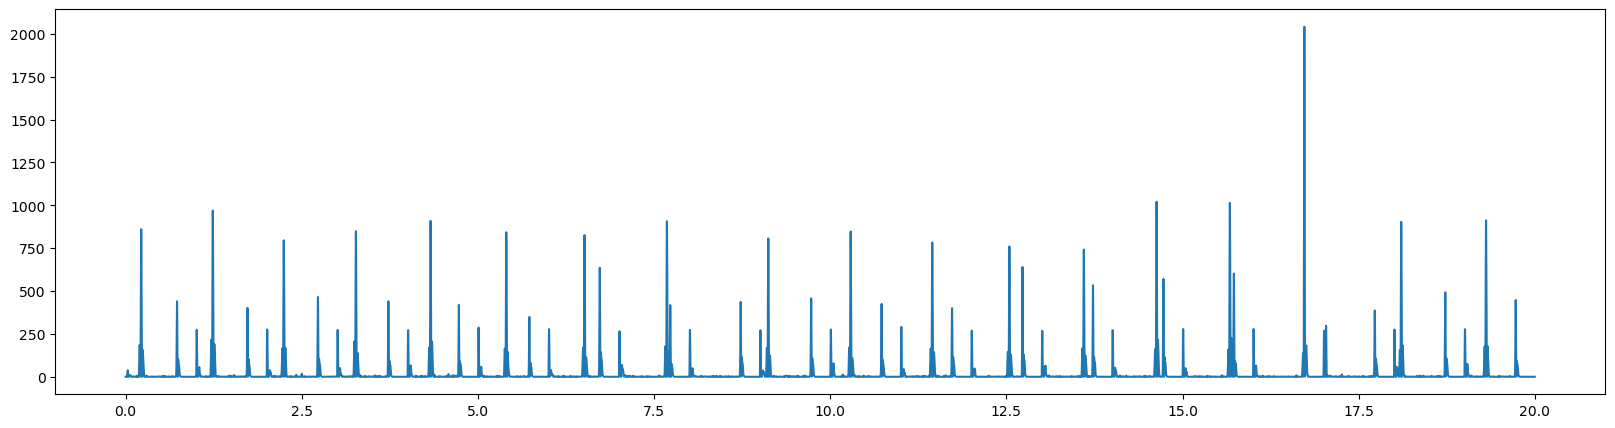

In [39]:
# Filtro cuadrado
f_sq = fd_signal**2
plt.figure(figsize=(20,5))
plt.plot(t, f_sq)
plt.show()

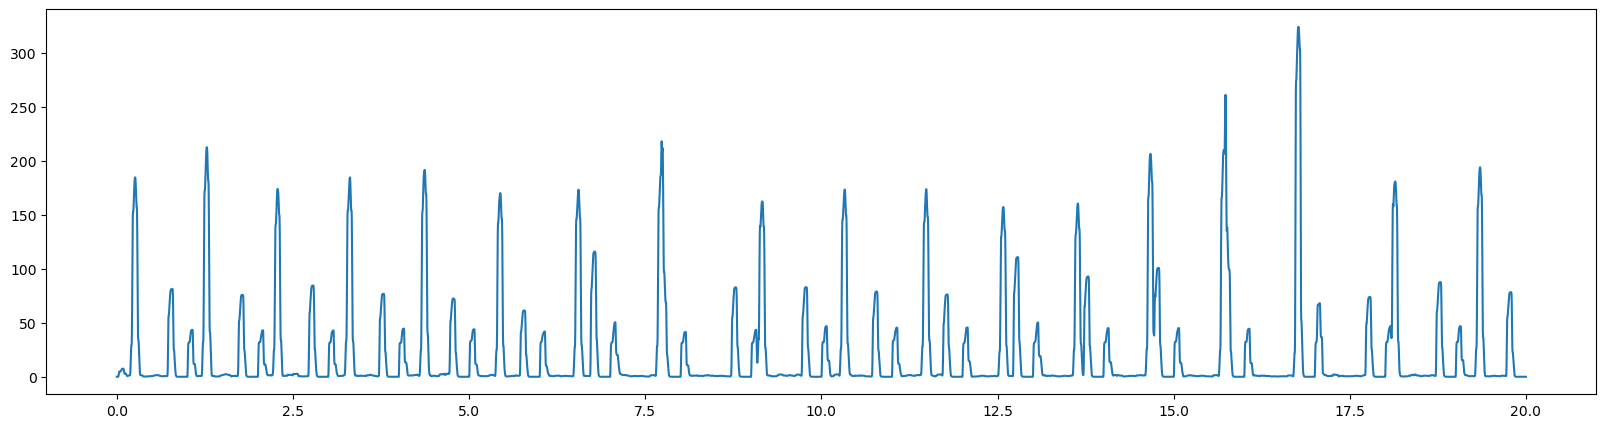

In [40]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(t,fi_signal)
plt.show()

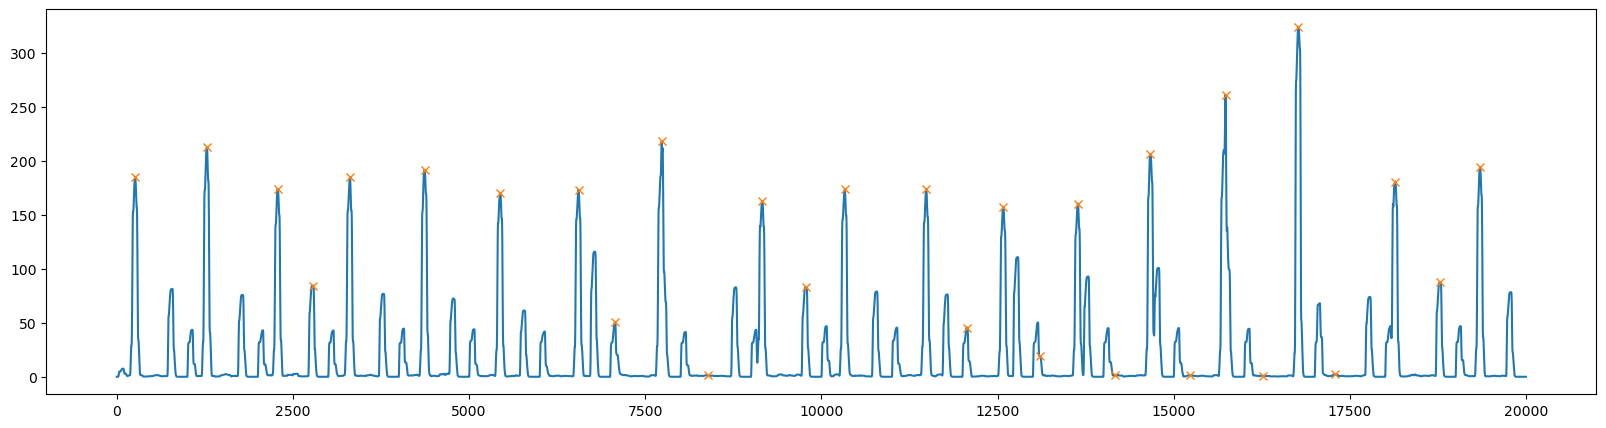

In [41]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=500)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

El valor del umbral de pico R de entrada es  129.74033958128354
El valor del umbral de ruido de entrada es  80.34523678048785


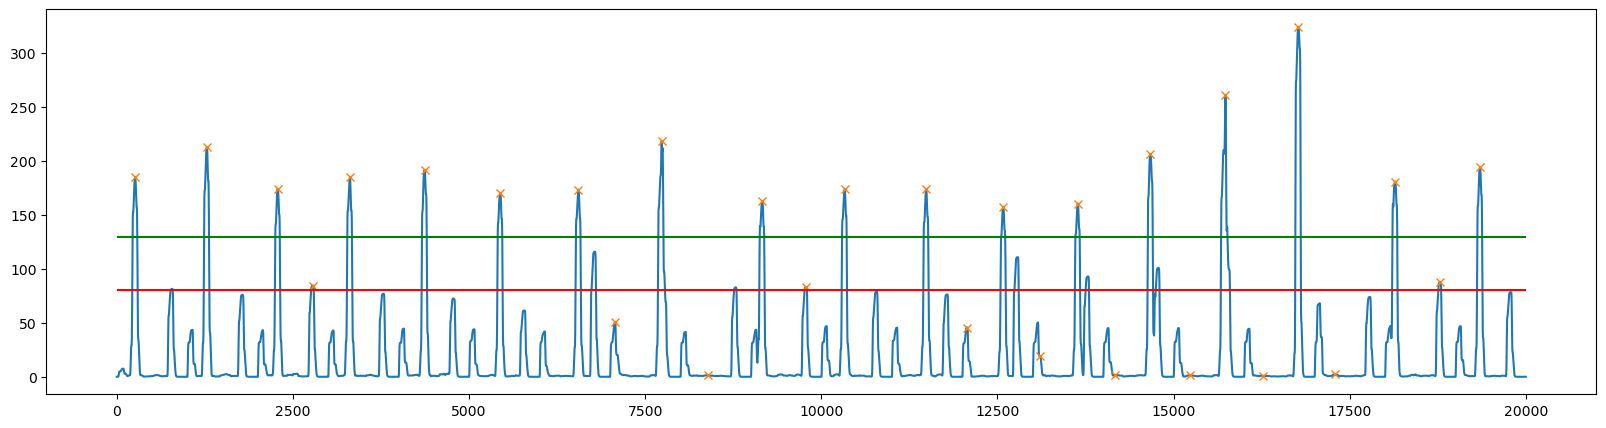

In [42]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.4
th_I2 = 0.6*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

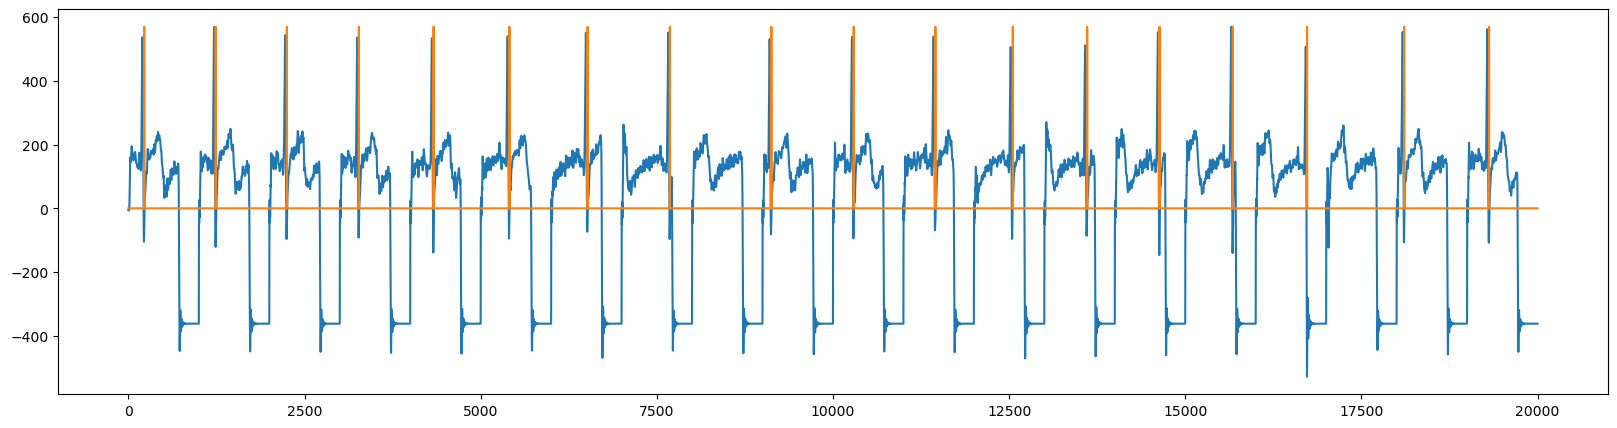

In [43]:

end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

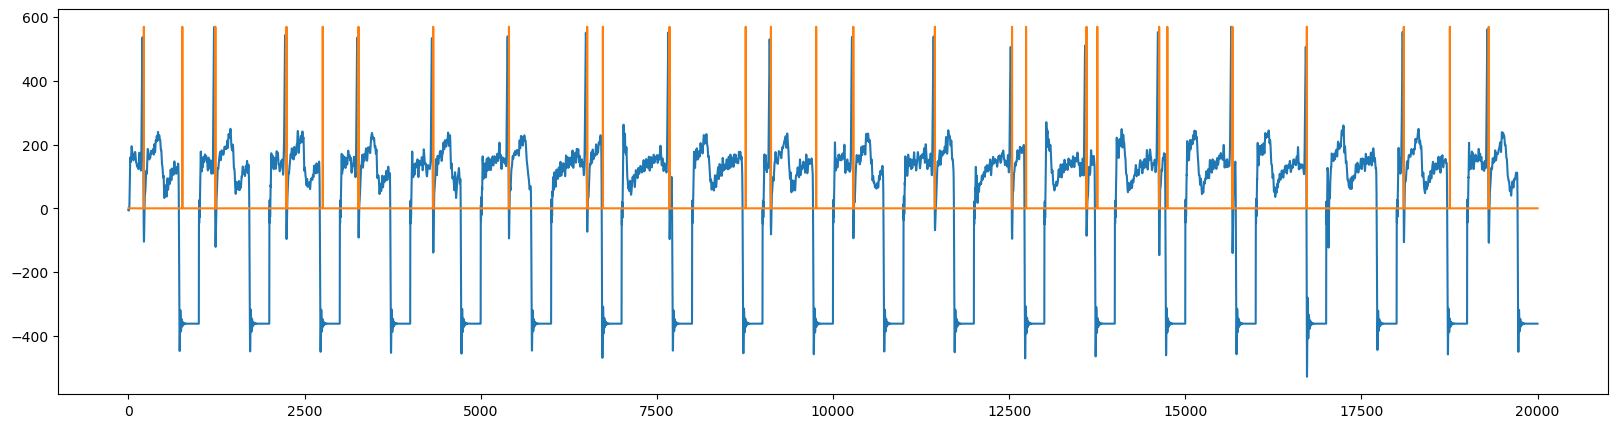

In [44]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

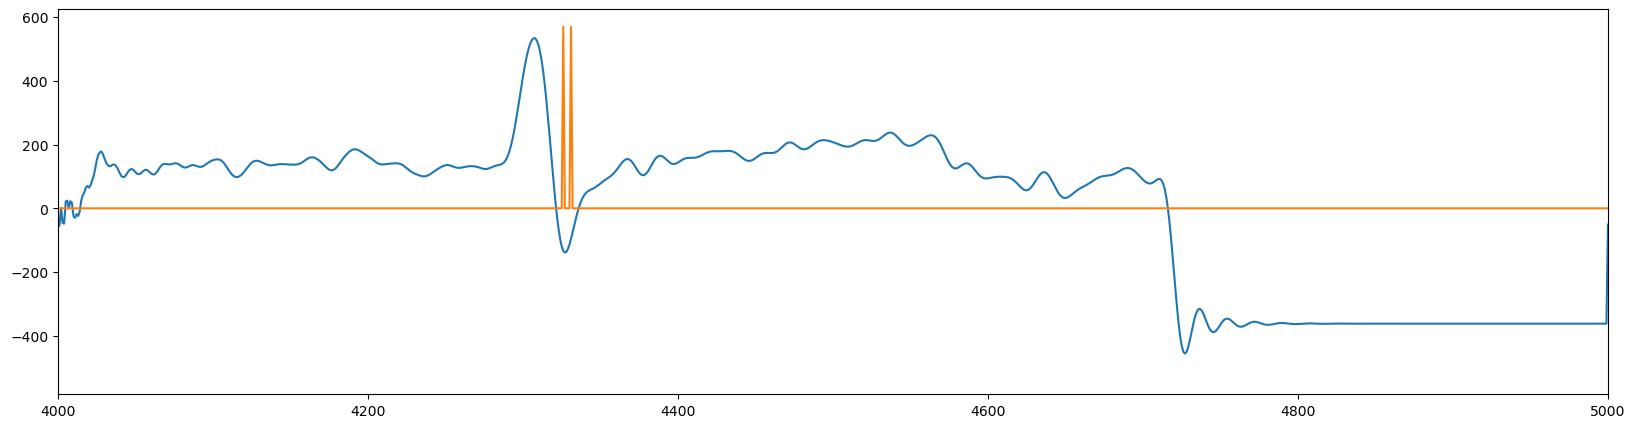

In [45]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.xlim(4000,5000)
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()

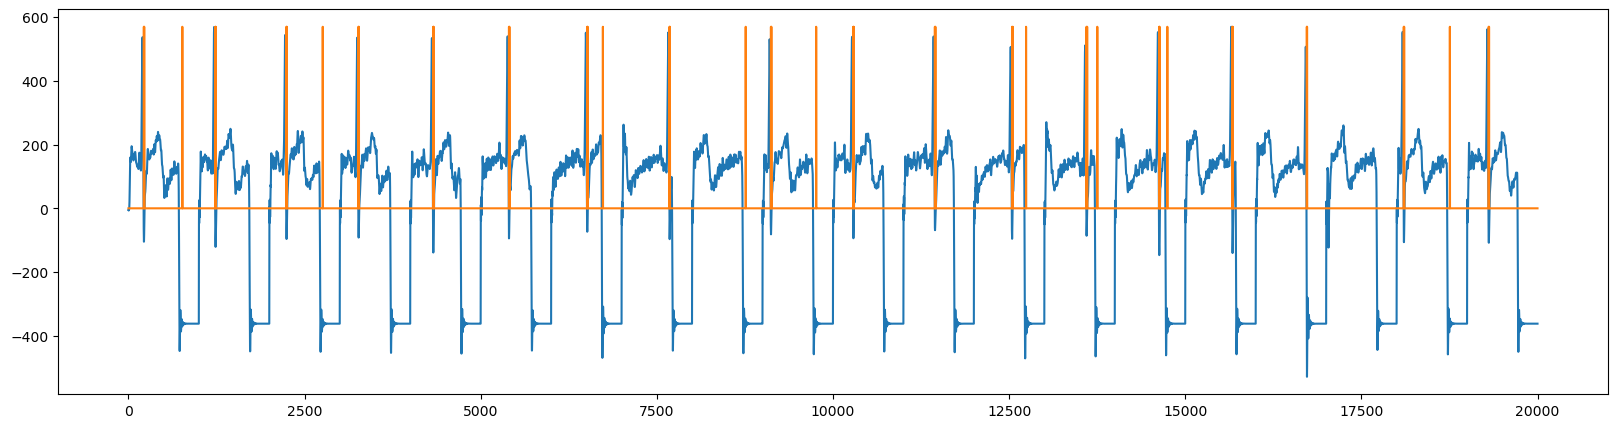

In [46]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()